In [1]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore
from pathlib import Path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

def get_bag_data (path):
    data = []
    timestamps = []
    typestore = get_typestore(Stores.ROS2_HUMBLE)
    with Reader(path) as reader:
        connections = [x for x in reader.connections if x.topic == '/output/lean_angle']
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            timestamps.append(timestamp)
            data.append(msg.data)

    np_data = np.array(data)
    np_time = (np.array(timestamps) - timestamps[0]) / 1e9
    return np_data, np_time

In [2]:
bags = glob("../bags/*")
bags.sort()

path = Path(bags[-1])
prev_path = Path(bags[-2])

data, time = get_bag_data(path)
prev_data, prev_time = get_bag_data(prev_path)

ValueError: x and y must have same first dimension, but have shapes (377,) and (441,)

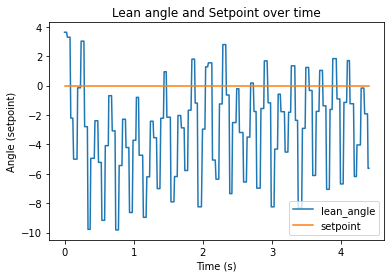

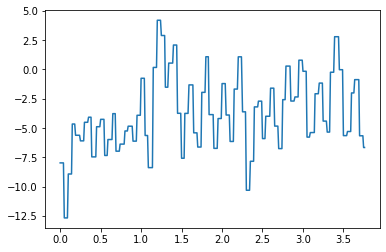

In [5]:
setpoint = 0
setpoint_array = np.ones(data.shape) * setpoint

#graph 1
plt.figure()
plt.plot(time, data)
plt.plot(time, setpoint_array)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (setpoint)")
plt.legend(["lean_angle", "setpoint"])

#graph 2
plt.figure()
plt.plot(prev_time, prev_data)
plt.plot(prev_time, np.ones(prev_time.shape) * setpoint)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (setpoint)")
plt.legend(["prev lean_angle", "setpoint"])